In [41]:
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima, arima

from meteostat import Hourly
from datetime import datetime

from scipy.signal import periodogram

In [2]:
df = pd.read_csv('./cleaned.csv')

# convert to datetime format
df.time = pd.to_datetime(df.time)
tz = pytz.timezone('US/Mountain')       # add timezone info

times = [t.replace(tzinfo=None) for t in df.time]     # first, save the time as unaware datetime
df['time_unaware'] = times
df['time_unaware'] = pd.to_datetime(df['time_unaware'])

times = [tz.localize(t) for t in df.time_unaware]     # add timezone info to unaware time
df['time'] = times
df = df.drop(['time_unaware'], axis=1)
df.head()

,EnergyDemand,time,WeightedTemp
0,4875.0,2015-07-01 01:00:00-06:00,20.530496
1,4618.0,2015-07-01 02:00:00-06:00,19.708924
2,4427.0,2015-07-01 03:00:00-06:00,18.780578
3,4344.0,2015-07-01 04:00:00-06:00,18.468283
4,4374.0,2015-07-01 05:00:00-06:00,17.556280


In [3]:
def sin_transformer(k, period):
    return FunctionTransformer(lambda x: np.sin(k * x / period * 2 * np.pi))

def cos_transformer(k, period):
    return FunctionTransformer(lambda x: np.cos(k * x / period * 2 * np.pi))

In [4]:
# Scale the data
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(df.drop(['time'], axis=1))
scaled = pd.DataFrame()
scaled['time'] = df['time']
scaled['EnergyDemand'] = scaled_ts[:,0]
scaled['WeightedTemp'] = scaled_ts[:,1]
scaled.head()

,time,EnergyDemand,WeightedTemp
0,2015-07-01 01:00:00-06:00,-0.389444,0.889616
1,2015-07-01 02:00:00-06:00,-0.692537,0.814249
2,2015-07-01 03:00:00-06:00,-0.917793,0.729087
3,2015-07-01 04:00:00-06:00,-1.015679,0.700439
4,2015-07-01 05:00:00-06:00,-0.980298,0.616777


In [5]:
spec_dens = periodogram(scaled.EnergyDemand)
spec = pd.DataFrame()
spec['frequency'] = spec_dens[0]
spec['period'] = 1 / spec_dens[0]
spec['density'] = spec_dens[1]

spec.sort_values(by='density', ascending=False).head(15)

/var/folders/c7/911byk5d5jl0vp7m92bxn01w0000gn/T/ipykernel_33766/1449349865.py:4: RuntimeWarning: divide by zero encountered in true_divide
  spec['period'] = 1 / spec_dens[0]


,frequency,period,density
2496,0.041672,23.997196,14794.817696
14,0.000234,4278.357143,5843.716848
1,0.000017,59897.000000,4633.566965
2495,0.041655,24.006814,2953.312058
13,0.000217,4607.461538,2812.100964
2489,0.041555,24.064685,2122.523687
4991,0.083326,12.001002,1824.845853
2497,0.041688,23.987585,996.790420
4992,0.083343,11.998598,967.646875
7,0.000117,8556.714286,880.340802


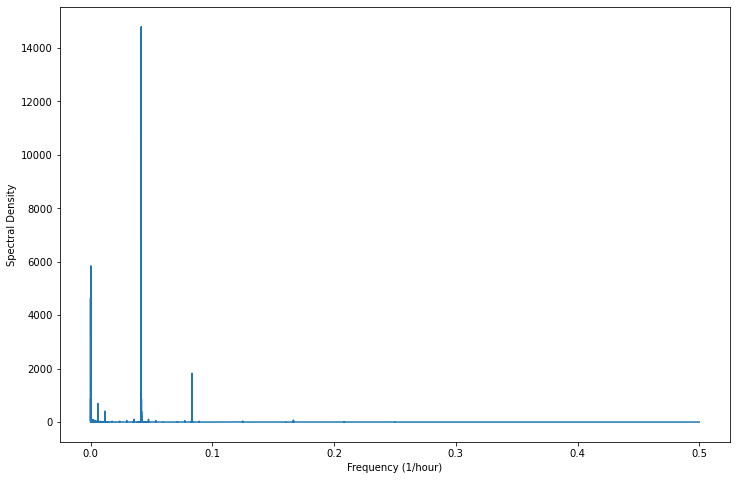

In [123]:
plt.figure(figsize=(12,8))
plt.plot(spec_dens[0], spec_dens[1])
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Spectral Density');

In [6]:
# Create features for model fitting
scaled['sq_WeightedTemp'] = scaled['WeightedTemp'] ** 2

scaled = scaled.reset_index()
scaled['timestep'] = scaled['index'] + 1

# for k in range(10):
#     for p in [24,4595,8533,168]:
    
#         name = 'k' + str(k+1) + '_period' + str(p)
    
#         scaled[name + '_sin'] = sin_transformer(k+1,p).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
#         scaled[name + '_cos'] = cos_transformer(k+1,p).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['daily_sin'] = sin_transformer(1,24).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['daily_cos'] = cos_transformer(1,24).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['semi_daily_sin'] = sin_transformer(1,12).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['semi_daily_cos'] = cos_transformer(1,12).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['weekly_sin'] = sin_transformer(1,168).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['weekly_cos'] = cos_transformer(1,168).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['semi_weekly_sin'] = sin_transformer(1,168/2).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['semi_weekly_cos'] = cos_transformer(1,168/2).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['yearly_sin'] = sin_transformer(1,24*365).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['yearly_cos'] = cos_transformer(1,24*365).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled['semi_yearly_sin'] = sin_transformer(1,24*365/2).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))
scaled['semi_yearly_cos'] = cos_transformer(1,24*365/2).fit_transform(scaled.timestep.to_numpy().reshape(-1,1))

scaled = scaled.drop(['index'], axis=1)
scaled.head()

,time,EnergyDemand,WeightedTemp,sq_WeightedTemp,timestep,daily_sin,daily_cos,semi_daily_sin,semi_daily_cos,weekly_sin,weekly_cos,semi_weekly_sin,semi_weekly_cos,yearly_sin,yearly_cos,semi_yearly_sin,semi_yearly_cos
0,2015-07-01 01:00:00-06:00,-0.389444,0.889616,0.791416,1,0.258819,0.965926,0.500000,8.660254e-01,0.037391,0.999301,0.074730,0.997204,0.000717,1.000000,0.001435,0.999999
1,2015-07-01 02:00:00-06:00,-0.692537,0.814249,0.663001,2,0.500000,0.866025,0.866025,5.000000e-01,0.074730,0.997204,0.149042,0.988831,0.001435,0.999999,0.002869,0.999996
2,2015-07-01 03:00:00-06:00,-0.917793,0.729087,0.531569,3,0.707107,0.707107,1.000000,6.123234e-17,0.111964,0.993712,0.222521,0.974928,0.002152,0.999998,0.004304,0.999991
3,2015-07-01 04:00:00-06:00,-1.015679,0.700439,0.490615,4,0.866025,0.500000,0.866025,-5.000000e-01,0.149042,0.988831,0.294755,0.955573,0.002869,0.999996,0.005738,0.999984
4,2015-07-01 05:00:00-06:00,-0.980298,0.616777,0.380414,5,0.965926,0.258819,0.500000,-8.660254e-01,0.185912,0.982566,0.365341,0.930874,0.003586,0.999994,0.007173,0.999974


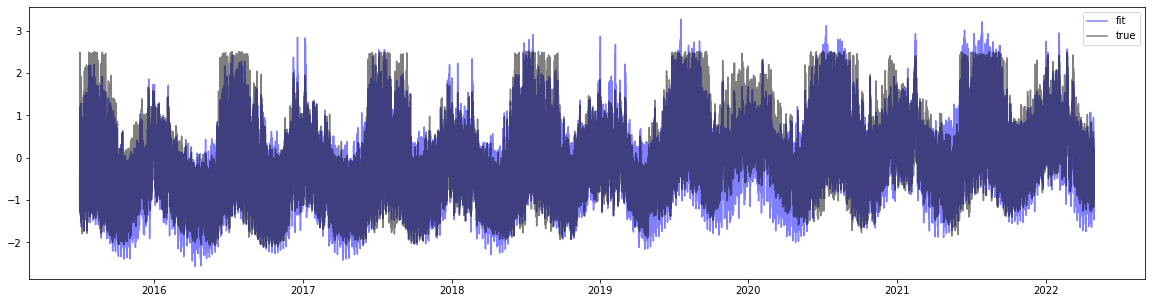

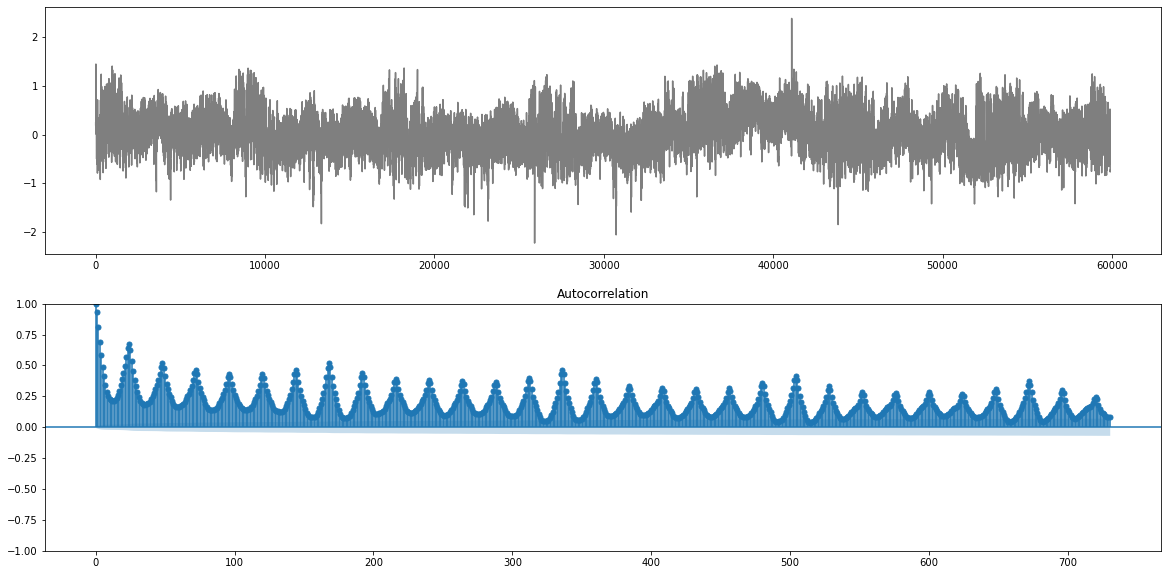

In [35]:
# X = scaled.drop(['time', 'EnergyDemand'], axis=1).to_numpy()
# y = scaled.loc[:,'EnergyDemand'].to_numpy()

# CV = TimeSeriesSplit(n_splits=5, gap=48) # gap of 2 days between splits
# for train_index, test_index in CV.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# alphas = np.logspace(-6, 6, 25)
# ridge = RidgeCV(alphas=alphas).fit(X_train,y_train)
# pred = ridge.predict(X_test)
# fit = ridge.predict(X_train)
# resid = y_train - fit

# print('Score: %.4f' %(ridge.score(X_test, y_test)) )
# print('MSE: %.4f' %(MSE(y_true=y_test, y_pred=pred)) )

plt.figure(figsize=(20,5))
plt.plot(scaled.iloc[:,0], fit, c='blue', alpha=0.5, label='fit')
plt.plot(scaled.iloc[:,0], y, c='black', alpha=0.5, label='true')
# plt.plot(scaled.iloc[test_index,0], pred, c='blue', alpha=0.5, label='prediction')
# plt.plot(scaled.iloc[test_index,0], y_test, c='red', alpha=0.5, label='true')
plt.legend();

# plt.figure(figsize=(20,5))
# plt.plot(pred, c='blue', alpha=0.5, label='prediction')
# plt.plot(y_test, c='red', alpha=0.5, label='true')
# plt.xlim(0,24*14)
# plt.legend();

# plt.figure(figsize=(20,5))
# plt.plot(resid, c='k', alpha=0.5, label='residuals')
# plt.legend();

fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(resid, c='k', alpha=0.5, label='residuals')
plot_acf(resid, ax=ax[1], lags=365*2);
# plot_pacf(resid, ax=ax[1], lags=365*2);

In [ ]:
# resid_train = y_train - fit
# resid_test = y_test - pred

# arima_model = auto_arima(y=resid_train, d=1, 
#                          start_p=1, max_p=5,
#                          start_q=1, max_q=5,
#                          seasonal=True, m=24,
#                          information_criterion='aic',
#                          trace=True)

# arima_model.fit(resid_train)
# forecast = model.predict(n_periods=len(resid_test))
# forecast = pd.DataFrame(forecast)
# forecast.head()

In [8]:
# Perform modeling on full dataset to use with ARIMA model chosen by auto_arima
X = scaled.drop(['time', 'EnergyDemand'], axis=1).to_numpy()
y = scaled.loc[:,'EnergyDemand'].to_numpy()

alphas = np.logspace(-6, 6, 25)
ridge = RidgeCV(alphas=alphas).fit(X,y)
fit = ridge.predict(X)
resid = y - fit

model = arima.ARIMA(order=(4,1,0), 
              seasonal_order=(2,0,0,24))
model.fit(resid)

ARIMA(order=(4, 1, 0), seasonal_order=(2, 0, 0, 24))

(19112.5, 19113.75)

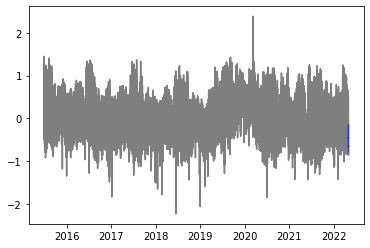

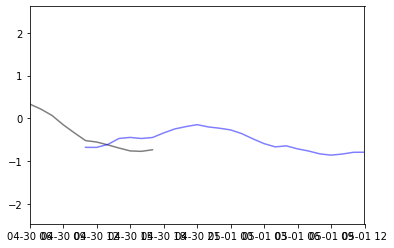

In [56]:
forecast_dates = pd.date_range(datetime(2022,4,30,17,0,0), datetime(2022,5,1,18,0,0), freq='H')

plt.plot(scaled.time, resid, c='k', alpha=0.5, label='true')
plt.plot(forecast_dates, preds, c='blue', alpha=0.5, label='prediction')

plt.figure()
plt.plot(scaled.time, resid, c='k', alpha=0.5, label='true')
plt.plot(forecast_dates, preds, c='blue', alpha=0.5, label='prediction')
plt.xlim((datetime(2022,4,30,12,0,0), datetime(2022,5,1,18,0,0)));

In [67]:
# Get forecast data
forecast = pd.read_csv('./forecast.csv')

# Scale the data
scaled_ts = scaler.fit_transform(forecast.drop(['time'], axis=1))
scaled_forecast = pd.DataFrame()
scaled_forecast['time'] = forecast['time']
scaled_forecast['WeightedTemp'] = scaled_ts
scaled_forecast.head()

,time,WeightedTemp
0,2022-04-30 18:00:00-06:00,1.225480
1,2022-04-30 19:00:00-06:00,0.963201
2,2022-04-30 20:00:00-06:00,0.584028
3,2022-04-30 21:00:00-06:00,0.245107
4,2022-04-30 22:00:00-06:00,-0.091461


In [68]:
# Create features for model fitting
scaled_forecast['sq_WeightedTemp'] = scaled_forecast['WeightedTemp'] ** 2

scaled_forecast = scaled_forecast.reset_index()
scaled_forecast['timestep'] = scaled_forecast['index'] + 1 + len(scaled)

scaled_forecast['daily_sin'] = sin_transformer(1,24).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['daily_cos'] = cos_transformer(1,24).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast['semi_daily_sin'] = sin_transformer(1,12).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['semi_daily_cos'] = cos_transformer(1,12).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast['weekly_sin'] = sin_transformer(1,168).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['weekly_cos'] = cos_transformer(1,168).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast['semi_weekly_sin'] = sin_transformer(1,168/2).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['semi_weekly_cos'] = cos_transformer(1,168/2).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast['yearly_sin'] = sin_transformer(1,24*365).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['yearly_cos'] = cos_transformer(1,24*365).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast['semi_yearly_sin'] = sin_transformer(1,24*365/2).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))
scaled_forecast['semi_yearly_cos'] = cos_transformer(1,24*365/2).fit_transform(scaled_forecast.timestep.to_numpy().reshape(-1,1))

scaled_forecast = scaled_forecast.drop(['index'], axis=1)
scaled_forecast.head()

scaled_forecast.head()

,time,WeightedTemp,sq_WeightedTemp,timestep,daily_sin,daily_cos,semi_daily_sin,semi_daily_cos,weekly_sin,weekly_cos,semi_weekly_sin,semi_weekly_cos,yearly_sin,yearly_cos,semi_yearly_sin,semi_yearly_cos
0,2022-04-30 18:00:00-06:00,1.225480,1.501800,59898,-1.000000,-3.217363e-13,6.434726e-13,-1.000000e+00,-0.222521,-0.974928,0.433884,0.900969,-0.852078,0.523416,-0.891981,-0.452072
1,2022-04-30 19:00:00-06:00,0.963201,0.927755,59899,-0.965926,2.588190e-01,-5.000000e-01,-8.660254e-01,-0.258819,-0.965926,0.500000,0.866025,-0.851702,0.524027,-0.892629,-0.450792
2,2022-04-30 20:00:00-06:00,0.584028,0.341089,59900,-0.866025,5.000000e-01,-8.660254e-01,-5.000000e-01,-0.294755,-0.955573,0.563320,0.826239,-0.851326,0.524637,-0.893275,-0.449511
3,2022-04-30 21:00:00-06:00,0.245107,0.060077,59901,-0.707107,7.071068e-01,-1.000000e+00,4.311621e-13,-0.330279,-0.943883,0.623490,0.781831,-0.850949,0.525248,-0.893919,-0.448229
4,2022-04-30 22:00:00-06:00,-0.091461,0.008365,59902,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,-0.365341,-0.930874,0.680173,0.733052,-0.850572,0.525858,-0.894561,-0.446947


In [77]:
# convert to datetime format
scaled_forecast.time = pd.to_datetime(scaled_forecast.time)
tz = pytz.timezone('US/Mountain')       # add timezone info

times = [t.replace(tzinfo=None) for t in scaled_forecast.time]     # first, save the time as unaware datetime
scaled_forecast['time_unaware'] = times
scaled_forecast['time_unaware'] = pd.to_datetime(scaled_forecast['time_unaware'])

times = [tz.localize(t) for t in scaled_forecast.time_unaware]     # add timezone info to unaware time
scaled_forecast['time'] = times
scaled_forecast = scaled_forecast.drop(['time_unaware'], axis=1)
scaled_forecast.head()

,time,WeightedTemp,sq_WeightedTemp,timestep,daily_sin,daily_cos,semi_daily_sin,semi_daily_cos,weekly_sin,weekly_cos,semi_weekly_sin,semi_weekly_cos,yearly_sin,yearly_cos,semi_yearly_sin,semi_yearly_cos
0,2022-04-30 18:00:00-06:00,1.225480,1.501800,59898,-1.000000,-3.217363e-13,6.434726e-13,-1.000000e+00,-0.222521,-0.974928,0.433884,0.900969,-0.852078,0.523416,-0.891981,-0.452072
1,2022-04-30 19:00:00-06:00,0.963201,0.927755,59899,-0.965926,2.588190e-01,-5.000000e-01,-8.660254e-01,-0.258819,-0.965926,0.500000,0.866025,-0.851702,0.524027,-0.892629,-0.450792
2,2022-04-30 20:00:00-06:00,0.584028,0.341089,59900,-0.866025,5.000000e-01,-8.660254e-01,-5.000000e-01,-0.294755,-0.955573,0.563320,0.826239,-0.851326,0.524637,-0.893275,-0.449511
3,2022-04-30 21:00:00-06:00,0.245107,0.060077,59901,-0.707107,7.071068e-01,-1.000000e+00,4.311621e-13,-0.330279,-0.943883,0.623490,0.781831,-0.850949,0.525248,-0.893919,-0.448229
4,2022-04-30 22:00:00-06:00,-0.091461,0.008365,59902,-0.500000,8.660254e-01,-8.660254e-01,5.000000e-01,-0.365341,-0.930874,0.680173,0.733052,-0.850572,0.525858,-0.894561,-0.446947


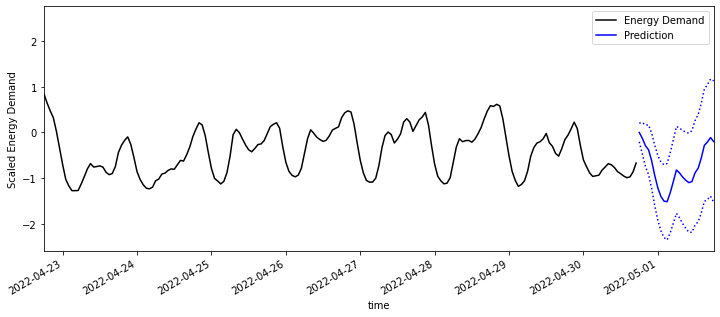

In [121]:
# Make model and ARIMA predictions, combine
arima_pred, conf_int = model.predict(n_periods=25, return_conf_int=True)

X_forecast = scaled_forecast.drop(['time'], axis=1).to_numpy()
model_pred = ridge.predict(X_forecast)
final_pred = model_pred + arima_pred
fig, ax = plt.subplots(1,1, figsize=(12,5))
scaled.plot(x='time', y='EnergyDemand', xlim=(datetime(2022,4,23), datetime(2022,5,2)), c='k', ax=ax, legend=True, label='Energy Demand')
ax.plot(scaled_forecast.time, final_pred, c='blue', label='Prediction')
ax.plot(scaled_forecast.time, conf_int[:,0] + model_pred, c='blue', ls='dotted')
ax.plot(scaled_forecast.time, conf_int[:,1] + model_pred, c='blue', ls='dotted')
ax.legend()
ax.set_ylabel('Scaled Energy Demand');

In [116]:
conf_int[:,0] = conf_int[:,0] + model_pred
conf_int[:,1] = conf_int[:,1] + model_pred

In [117]:
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(df.drop(['time','WeightedTemp'], axis=1))
unscaled_pred = scaler.inverse_transform(final_pred.reshape(-1,1))
unscaled_conf = scaler.inverse_transform(conf_int)

forecast['EnergyDemandPrediction'] = unscaled_pred
forecast['LowerConfInt'] = unscaled_conf[:,0]
forecast['UpperConfInt'] = unscaled_conf[:,1]
forecast

,time,WeightedTemp,EnergyDemandPrediction,LowerConfInt,UpperConfInt
0,2022-04-30 18:00:00-06:00,17.571433,5205.215300,5031.898137,5378.532463
1,2022-04-30 19:00:00-06:00,16.434811,5096.240875,4804.554365,5387.927386
2,2022-04-30 20:00:00-06:00,14.791616,4959.599532,4575.555017,5343.644048
3,2022-04-30 21:00:00-06:00,13.322854,4885.360291,4427.720584,5342.999997
4,2022-04-30 22:00:00-06:00,11.864292,4682.040894,4168.914646,5195.167141
5,2022-04-30 23:00:00-06:00,10.780082,4408.811368,3850.232223,4967.390512
6,2022-05-01 00:00:00-06:00,9.575867,4179.249818,3580.339477,4778.160159
7,2022-05-01 01:00:00-06:00,8.910533,4019.840448,3383.402847,4656.278050
8,2022-05-01 02:00:00-06:00,8.168185,3934.767028,3262.388473,4607.145583
9,2022-05-01 03:00:00-06:00,7.504237,3925.699983,3218.700240,4632.699727


In [124]:
6159.35 - 5036.95

1122.4000000000005